# mel2wav

## [seq] import

In [1]:
import json
import yaml
import sys
import IPython.display as ipd
import pprint
from pathlib import Path
from tqdm import tqdm

import numpy as np
import torch
import torchaudio
from librosa.filters import mel as librosa_mel_fn
#import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from scipy.io.wavfile import write


import toybox

In [2]:
def plot_audio(audio, samplerate, title='time-domain waveform'):
    """
    usage:
        # audio is [channel, time(num_frames)] ex.torch.Size([1, 68608])
        # audio[0,:]: list of 1ch audio data
        # audio.shape[1]: int value of 1ch audio data length
        audio, sample_rate = torchaudio.load(str(iwav_path))
        %matplotlib inline
        plot_audio(audio, sample_rate)
    """
    # transform to mono
    channel = 0
    audio = audio[channel,:].view(1,-1)
    # to numpy
    audio = audio.to('cpu').detach().numpy().copy()
    time = np.linspace(0., audio.shape[1]/samplerate, audio.shape[1])
    
    fig, ax = plt.subplots(figsize=(12,9))
    
    ax.plot(time, audio[0, :])
    ax.set_title(title, fontsize=20, y=-0.12)
    ax.tick_params(direction='in')
    #ax.set_xlim(0, 3)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amp')
    #ax.legend()
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()
    #fig.savefig('figure.png')
    plt.close(fig)
    return fig

def plot_mel(tensors:list, titles:list[str]):
    """
    usage:
        mel = mel_process(...)
        fig_mel = plot_mel([mel_groundtruth[0], mel_prediction[0]],
                            ['groundtruth', 'inferenced(model)'])

    """
    xlim = max([t.shape[1] for t in tensors])
    fig, axs = plt.subplots(nrows=len(tensors),
                            ncols=1,
                            figsize=(12, 9),
                            constrained_layout=True)

    if len(tensors) == 1:
        axs = [axs]
    
    for i in range(len(tensors)):
        im = axs[i].imshow(tensors[i],
                           aspect="auto",
                           origin="lower",
                           interpolation='none')
        plt.colorbar(im, ax=axs[i])
        axs[i].set_title(titles[i])
        axs[i].set_xlim([0, xlim])
    fig.canvas.draw()
    plt.show()
    plt.close()
    return fig

## [seq] check configuration

In [3]:
config = toybox.load_yaml_and_expand_var('configs/config_exp_PBL.yaml')

In [4]:
model_name = config['model_name']
runtime_name = config['runtime_name']
print(model_name)
print(runtime_name)

gradseptts
infer4PBL


In [5]:
n_mels: int = config['n_mels'] # 80
n_fft: int = config['n_fft'] # 1024
sample_rate: int = config['sample_rate'] # 22050
hop_size: int = config['hop_size'] # 256
win_size: int = config['win_size'] # 1024
f_min: int = config['f_min'] # 0
f_max: int = config['f_max'] # 8000
random_seed: int = config['random_seed'] # 42 or 1234

In [6]:
print(n_mels, n_fft, sample_rate, hop_size, win_size, f_min, f_max, random_seed)

80 1024 22050 256 1024 0 8000 42


### [seq] path for HiFi-GAN

In [7]:
# setting file paths
# from https://github.com/huawei-noah/Speech-Backbones/tree/main/Grad-TTS/hifi-gan
# https://drive.google.com/drive/folders/1-eEYTB5Av9jNql0WGBlRoi-WH2J7bp5Y?usp=sharing
HiFiGAN_CONFIG = './hifigan/official_pretrained/LJ_V2/config.json'
HiFiGAN_ckpt = './hifigan/official_pretrained/LJ_V2/generator_v2'

from hifigan import models, env

with open(HiFiGAN_CONFIG) as f:
    hifigan_hparams = env.AttrDict(json.load(f))

In [8]:
random_seed = hifigan_hparams.seed
print(random_seed)

1234


## [seq] device setting¶

In [9]:
import os

print(f"all cpu at using device: {os.cpu_count()}")
print(f"Number of available CPU: {len(os.sched_getaffinity(0))}") # Number of available CPUs can also be obtained. ,use systemcall at linux.
print(f"GPU_name: {torch.cuda.get_device_name()}\nGPU avail: {torch.cuda.is_available()}\n")

all cpu at using device: 52
Number of available CPU: 4
GPU_name: NVIDIA A100-PCIE-40GB
GPU avail: True



In [10]:
DEVICE = 'cpu' #'cuda' or 'cpu'
DEVICE_HiFiGAN = 'cuda'
if torch.cuda.is_available():
    print('use cuda')
else:
    os._exit(os.EX_OK)
    print('use cpu')

device = torch.device(DEVICE_HiFiGAN)
print(f'device: {device}')

use cuda
device: cuda


In [11]:
toybox.set_seed(random_seed)

## [seq] setting path

In [12]:
test_ds_path = Path(config['test_datalist_path'])

if model_name == 'groundtruth':
    IMEL_DIR_PATH = Path('./result4eval/infer4PBL/groundtruth/cuda/mel/')
else:
    IMEL_DIR_PATH = Path(f'./result4eval/{runtime_name}/{model_name}/{DEVICE}/mel')

RESULT_DIR_PATH = Path(f'./result4eval/{runtime_name}/{model_name}/{DEVICE}')
RESULT_WAV_DIR_PATH = RESULT_DIR_PATH / 'wav'

In [13]:
print('-------------------------------------------')
if IMEL_DIR_PATH.exists():
    print(f'Exists {IMEL_DIR_PATH}')
else:
    print(f'No exist {IMEL_DIR_PATH}')

print('-------------------------------------------')
if test_ds_path.exists():
    print(f'Exists {str(test_ds_path)}')
    with open(config['test_datalist_path']) as j:
        test_ds_list = json.load(j)
    print(f'loaded {test_ds_path}')
else:
    print(f'No exist {test_ds_path}')

print('-------------------------------------------')
if RESULT_DIR_PATH.exists():
    print(f'Exists {RESULT_DIR_PATH}')
else:
    #RESULT_DIR_PATH.mkdir(parents=True)
    print(f'No exist {RESULT_DIR_PATH}')

print('-------------------------------------------')
if RESULT_WAV_DIR_PATH.exists():
    print(f'Exists {RESULT_WAV_DIR_PATH}')
else:
    RESULT_WAV_DIR_PATH.mkdir(parents=True)
    print(f'Make {RESULT_WAV_DIR_PATH}')

-------------------------------------------
Exists result4eval/infer4PBL/gradseptts/cpu/mel
-------------------------------------------
Exists configs/test_dataset.json
loaded configs/test_dataset.json
-------------------------------------------
Exists result4eval/infer4PBL/gradseptts/cpu
-------------------------------------------
Make result4eval/infer4PBL/gradseptts/cpu/wav


## [seq] load HiFi-GAN

In [14]:

# Setup HiFi-GAN ====================
"""
from hifigan import models, env

with open(HiFiGAN_CONFIG) as f:
    hifigan_hparams = env.AttrDict(json.load(f))
"""
# generator ===================
print("[seq] loading HiFiGAN")
vocoder = models.Generator(hifigan_hparams)

vocoder.load_state_dict(torch.load(
    HiFiGAN_ckpt, map_location=device)['generator'])
vocoder = vocoder.eval().to(device)
vocoder.remove_weight_norm()

# UTMOS ===================
print("[seq]loading UTMOS")
predictor_utmos = torch.hub.load("tarepan/SpeechMOS:v1.2.0", "utmos22_strong", trust_repo=True)

[seq] loading HiFiGAN


/work/sora-sa/aoi/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


## [seq] test mel2wav

torch.Size([80, 646])


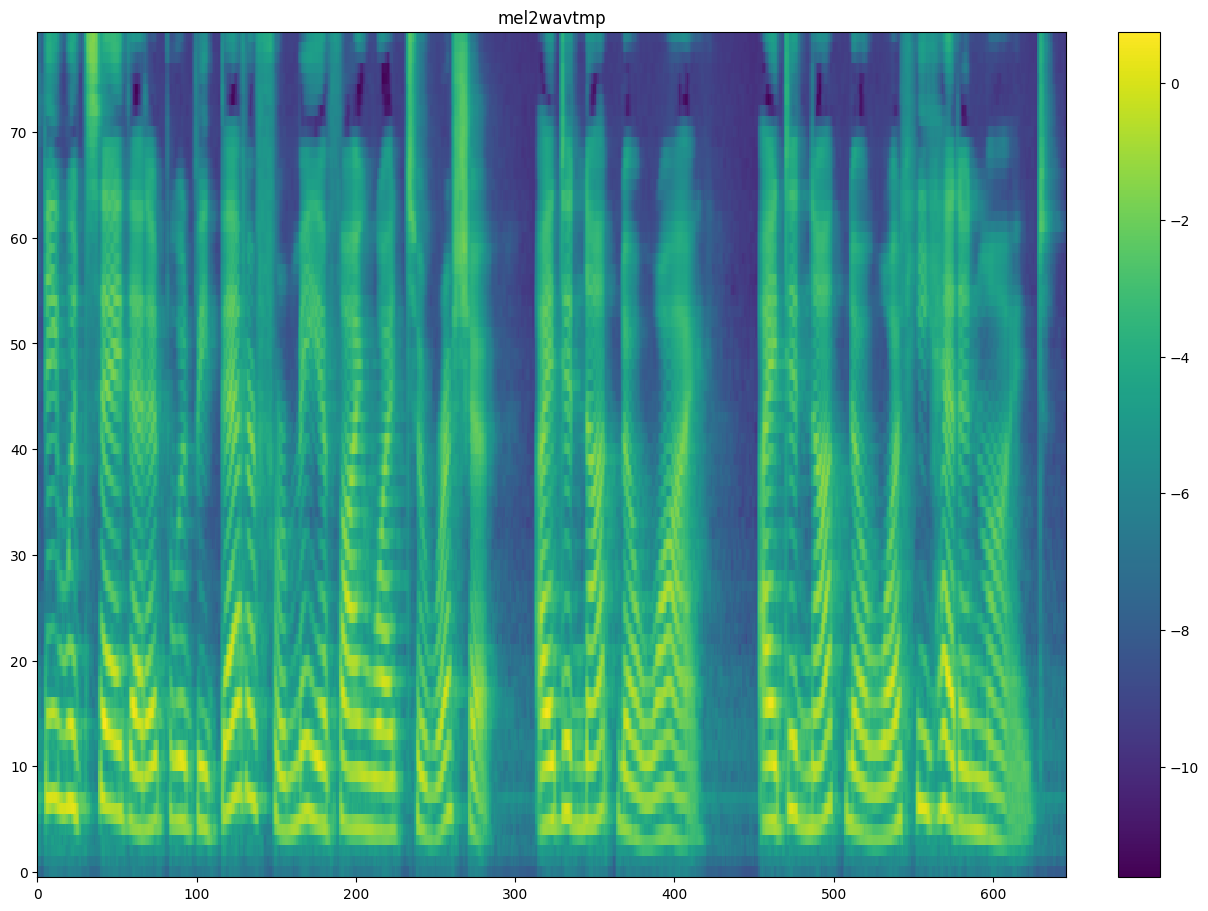

In [15]:
# test plot
x = np.load(IMEL_DIR_PATH / f"{test_ds_list[0]['name']}.npy") # [1, n_mel, n_frame]
x4plot = torch.FloatTensor(x).to(device)
x4plot = x4plot.squeeze().cpu()
print(x4plot.shape)
fig_meltmp = plot_mel([x4plot], ['mel2wavtmp'])

In [16]:
x2audio = torch.FloatTensor(x).to(device)
x2audio = x2audio.squeeze().unsqueeze(0)
print(f'x2audio.shape: {x2audio.shape}')
# x2audio is [1, n_mels, n_frames]
assert x2audio.shape[0] == 1
with torch.no_grad():
    # vocoder.forward(x).cpu() is torch.Size([1, 1, 167168])
    audio = (vocoder.forward(x2audio).cpu().squeeze().clamp(-1,1).numpy() * 32768).astype(np.int16)

x2audio.shape: torch.Size([1, 80, 646])


In [17]:
ipd.display(ipd.Audio(audio, rate=22050))

In [18]:
x2audio.shape

torch.Size([1, 80, 646])

## [seq] save mel2wav

In [19]:
infer_data_num: int = 100 #len(test_ds_list) is 200
print(infer_data_num)
print(RESULT_WAV_DIR_PATH)

100
result4eval/infer4PBL/gradseptts/cpu/wav


In [20]:
for i in tqdm(range(infer_data_num)):
    x = np.load(IMEL_DIR_PATH / f"{test_ds_list[i]['name']}.npy") # [1, n_mel, n_frame]
    x2audio = torch.FloatTensor(x).to(device)
    x2audio = x2audio.squeeze().unsqueeze(0)
    # x2audio is [1, n_mels, n_frames]
    assert x2audio.shape[0] == 1
    with torch.no_grad():
        # vocoder.forward(x).cpu() is torch.Size([1, 1, 167168])
        audio = (vocoder.forward(x2audio).cpu().squeeze().clamp(-1,1).numpy() * 32768).astype(np.int16)
    write(
        RESULT_WAV_DIR_PATH / f"{test_ds_list[i]['name']}.wav",
        hifigan_hparams.sampling_rate,
        audio)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.44it/s]


In [21]:
print('fin')

fin


In [23]:
n = 99
sample_audio, sample_rate = torchaudio.load(str(RESULT_WAV_DIR_PATH / f"{test_ds_list[n]['name']}.wav")) # audio is [channel, time] ex.torch.Size([1, 68608])
print(RESULT_WAV_DIR_PATH / f"{test_ds_list[n]['name']}.wav")
if sample_rate != config['sample_rate']:
    sample_audio = torchaudio.functional.resample(sample_audio, sample_rate, config['sample_rate'])

ipd.display(ipd.Audio(sample_audio, rate=22050))

result4eval/infer4PBL/gradseptts/cpu/wav/LJ029-0081.wav
